Imports

In [1]:
import os
import sys
import datetime as dt

import numpy as np
import pandas as pd
import gym
import quantstats as qs
import matplotlib.pyplot as plt

sys.path.append(os.path.join(".."))
import gym_anytrading

from stable_baselines3.common.vec_env import DummyVecEnv

C:\Users\olith\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


Create environment

In [2]:
# TICKERS = ["NESZ", "CIMB", "MAY", "KLK"]
TICKERS = ["AMM", "CIMB", "DIGI", "GAM", "GENM", "GENT", "HLBK", "IOI", "KLK", "MAY", "MISC", "NESZ", "PBK", "PEP", "PETD", "PTG", "RHBBANK", "ROTH", "T", "TNB"]
df = {}
directions_df = {}
dividends_df = {}
for ticker in TICKERS:
    df[ticker] = pd.read_csv(os.path.join("day_data", f"{ticker} MK Equity.csv"), parse_dates=True, index_col="Dates")
    d_df =  pd.read_csv(os.path.join("directions", f"Directions {ticker}.csv"), parse_dates=True, index_col="Dates")
    direction_start = d_df.index.get_loc(dt.datetime(2018, 1, 1)) + 1
    direction_end = d_df.index.get_loc(dt.datetime(2020, 1, 1))
    directions_df[ticker] = d_df.iloc[direction_start:direction_end]
    dividends_df[ticker] = pd.read_csv(os.path.join("dividends", f"{ticker} dividend.csv"), parse_dates=True, index_col="Date")

window_size = 30

val_start = df[TICKERS[0]].index.get_loc(dt.datetime(2018, 1, 1))
val_end = df[TICKERS[0]].index.get_loc(dt.datetime(2020, 1, 1))
print(val_start, val_end)

env_maker_val = lambda: gym.make(
    "daily-v0",
    df=df,
    window_size=window_size,
    frame_bound=(val_start, val_end),
    bankroll=100000.,
    dividends=dividends_df
)

env_val = DummyVecEnv([env_maker_val])

4695 5217
AMM
CIMB
DIGI
GAM
GENM
GENT
HLBK
IOI
KLK
MAY
MISC
NESZ
PBK
PEP
PETD
PTG
RHBBANK
ROTH
T
TNB
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space


# Buy and hold baseline

In [3]:
env = env_maker_val()
observation = env.reset()

c = 0
cash_holding = []
while True:
    c += 1
    action = np.ones(len(TICKERS) + 1, dtype=np.float)
    action[0] = 0
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])
    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)

AMM
CIMB
DIGI
GAM
GENM
GENT
HLBK
IOI
KLK
MAY
MISC
NESZ
PBK
PEP
PETD
PTG
RHBBANK
ROTH
T
TNB
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': -940.2114009999992, 'total_profit': -940.2114009999992, 'position': array([ 226.778599, 1273.      ,  945.      , 1115.      , 1303.      ,
       1516.      ,  822.      ,  285.      , 1067.      ,  199.      ,
        575.      ,  594.      ,   33.      , 1255.      ,  260.      ,
        215.      ,  296.      ,  865.      ,  325.      , 1293.      ,
        370.      ]), 'delta': array([ 17.266,   6.   ,  -1.   ,   3.   ,  10.   , -18.   ,   1.   ,
         0.   ,   4.   ,  -3.   ,  -7.   ,   0.   ,   0.   ,  -6.   ,
         7.   ,  -2.   ,   5.   ,   6.   ,  -2.   ,  10.   ,  -8.   ]), 'net_worth': 99059.7885990002}
Iterations: 521
Average cash: 0.19300802855662186


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             94.0%

Cumulative Return          -0.33%
CAGR﹪                     -0.16%

Sharpe                     0.03
Smart Sharpe               0.03
Sortino                    0.04
Smart Sortino              0.04
Sortino/√2                 0.03
Smart Sortino/√2           0.03
Omega                      1.01

Max Drawdown               -11.04%
Longest DD Days            438
Volatility (ann.)          9.81%
Calmar                     -0.01
Skew                       -0.74
Kurtosis                   3.99

Expected Daily %           -0.0%
Expected Monthly %         -0.01%
Expected Yearly %          -0.16%
Kelly Criterion            0.3%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.02%
Expected Shortfall (cVaR)  -1.02%

Gain/Pain Ratio            0.01
Gain/Pain (1M)             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-04-20,2018-12-17,2019-07-02,438,-11.043199,-10.114540
2,2019-07-03,2019-10-09,2019-12-31,181,-8.911452,-8.504199
3,2018-01-30,2018-04-04,2018-04-19,79,-4.037646,-3.726338
4,2018-01-09,2018-01-18,2018-01-25,16,-1.537403,-1.459829


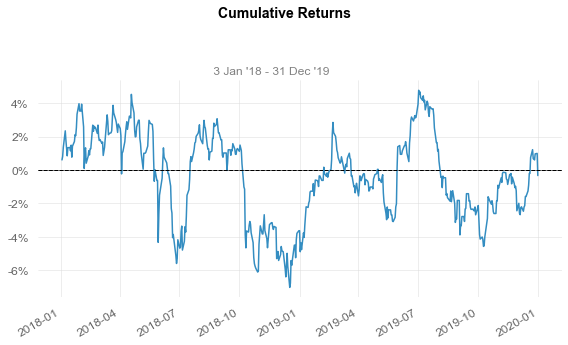

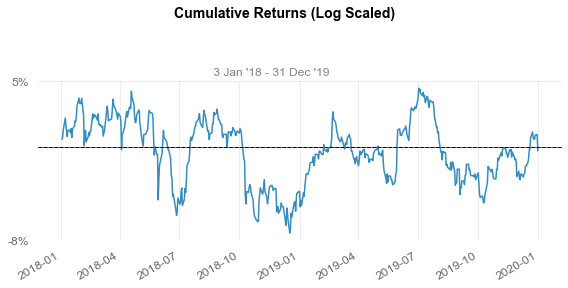

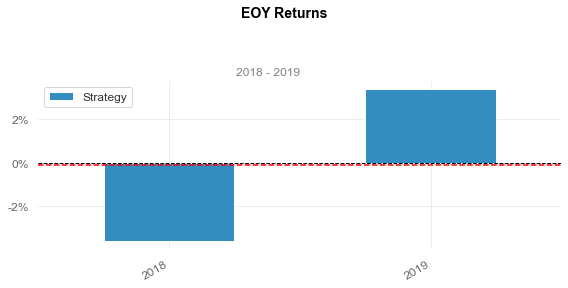

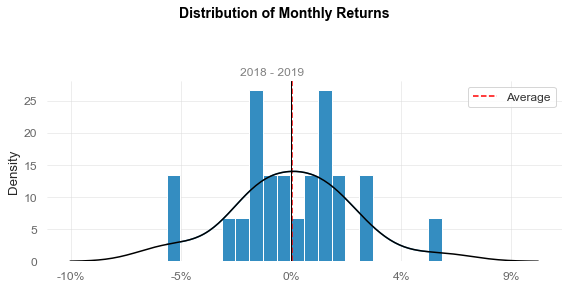

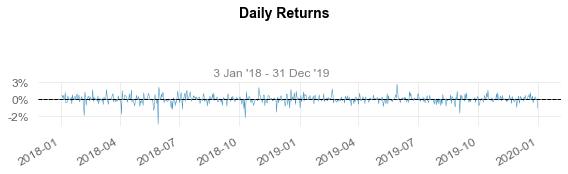

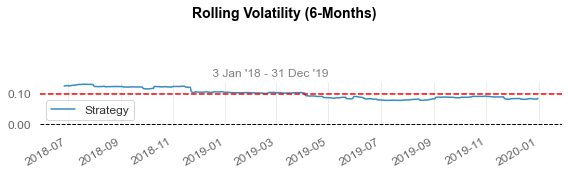

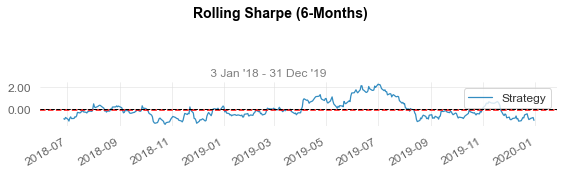

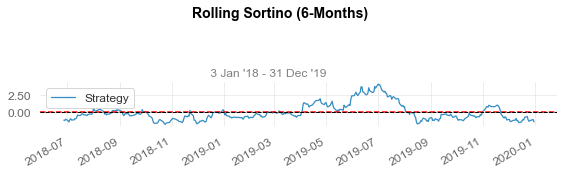

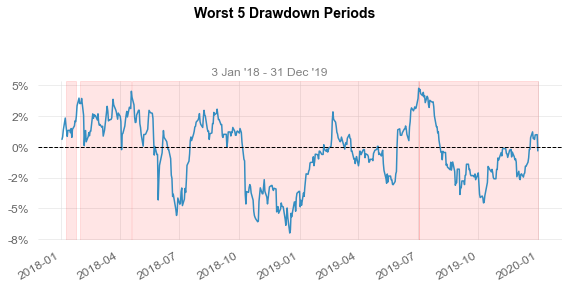

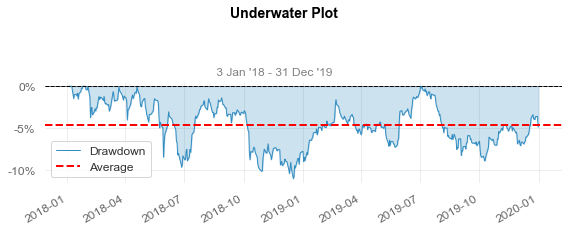

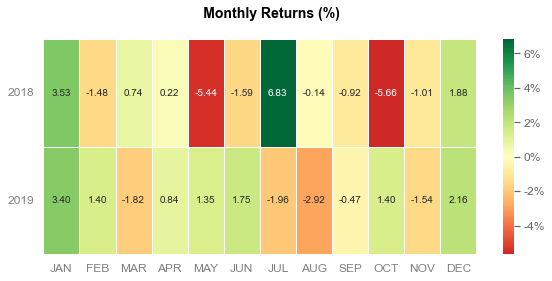

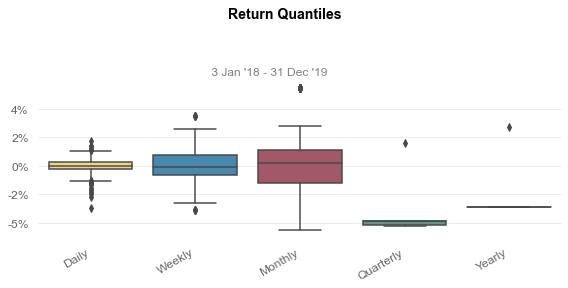

In [4]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Momentum baseline

In [5]:
env = env_maker_val()
observation = env.reset()

c = 0
cash_holding = []
stock_ts = 0
while True:
    c += 1
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i in range(len(TICKERS)):
        if observation[-1, i, 1] > 0:
            action[i + 1] = 1.

    if np.sum(action[1:]) == 0:
        action[0] = 1.
    else:
        action[0] = 0.
        stock_ts += 1

    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

AMM
CIMB
DIGI
GAM
GENM
GENT
HLBK
IOI
KLK
MAY
MISC
NESZ
PBK
PEP
PETD
PTG
RHBBANK
ROTH
T
TNB
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 7010.010079000001, 'total_profit': 7010.010079000001, 'position': array([ 108.658079, 2119.      , 1572.      ,    0.      ,    0.      ,
       2522.      , 1368.      ,  474.      , 1776.      ,    0.      ,
          0.      ,  989.      ,   56.      , 2089.      ,  432.      ,
        358.      ,    0.      , 1439.      ,    0.      , 2152.      ,
          0.      ]), 'delta': array([   62.056,  -920.   ,  1572.   , -2668.   ,     0.   , -1158.   ,
        -601.   ,   474.   ,  -773.   ,     0.   , -1397.   ,   989.   ,
          56.   ,  2089.   ,  -177.   ,   358.   ,     0.   ,  1439.   ,
        -786.   ,  2152.   ,  -907.   ]), 'net_worth': 107010.01007899999}
Iterations: 521
Average cash: 7.9527096449088255
Time steps with stock: 92.13051823416507


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             86.0%

Cumulative Return          8.02%
CAGR﹪                     3.95%

Sharpe                     0.41
Smart Sharpe               0.38
Sortino                    0.6
Smart Sortino              0.55
Sortino/√2                 0.42
Smart Sortino/√2           0.39
Omega                      1.08

Max Drawdown               -10.49%
Longest DD Days            181
Volatility (ann.)          10.58%
Calmar                     0.38
Skew                       0.24
Kurtosis                   4.18

Expected Daily %           0.01%
Expected Monthly %         0.32%
Expected Yearly %          3.93%
Kelly Criterion            3.6%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.08%
Expected Shortfall (cVaR)  -1.08%

Gain/Pain Ratio            0.08
Gain/Pain (1M)             0.42



None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-07-03,2019-10-09,2019-12-31,181,-10.488717,-10.118094
2,2018-08-29,2018-12-17,2019-01-31,155,-8.889572,-7.581140
3,2018-04-20,2018-05-30,2018-08-01,103,-7.058915,-6.544624
4,2019-02-22,2019-05-23,2019-06-19,117,-5.555102,-5.161953
5,2018-03-14,2018-04-04,2018-04-19,36,-4.882353,-2.989081


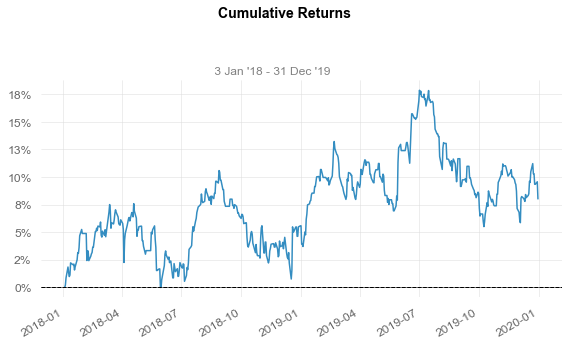

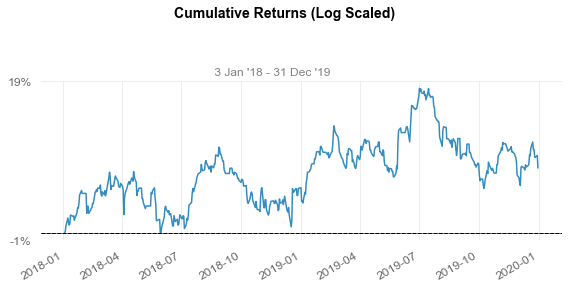

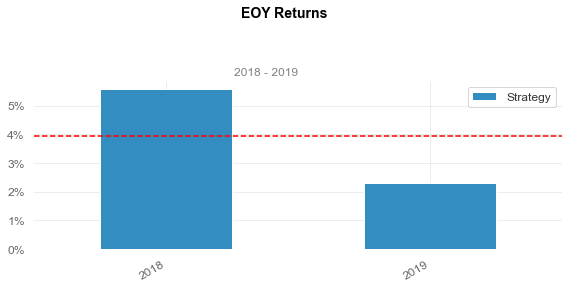

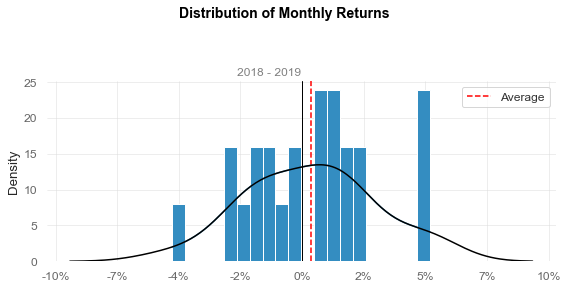

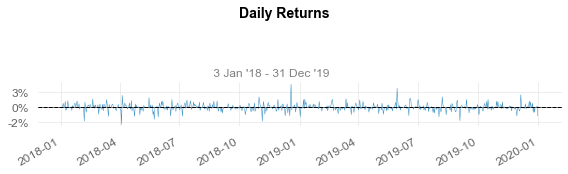

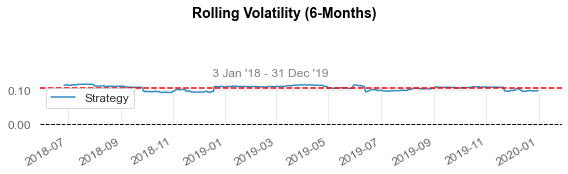

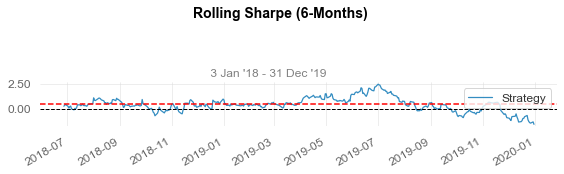

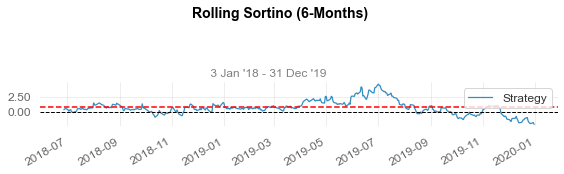

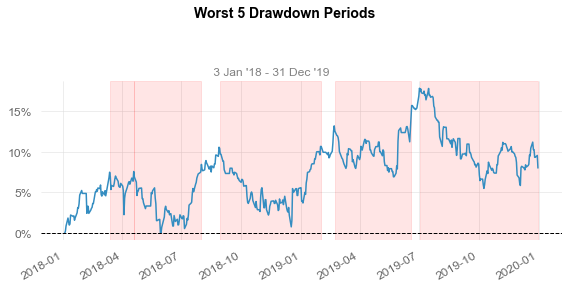

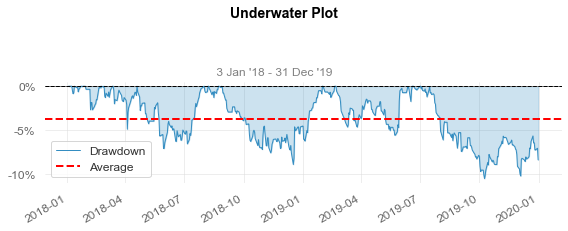

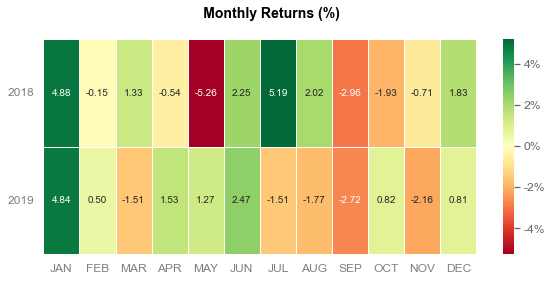

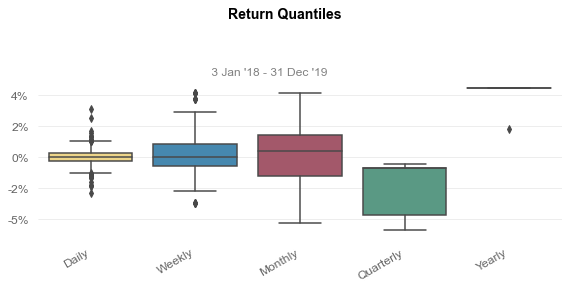

In [6]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Mean Reversion Baseline

In [7]:
env = env_maker_val()
observation = env.reset()

c = 0
cash_holding = []
stock_ts = 0
while True:
    c += 1
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i in range(len(TICKERS)):
        if observation[-1, i, 1] < 0:
            action[i + 1] = 1.

    if np.sum(action[1:]) == 0:
        action[0] = 1.
    else:
        action[1] = 0.
        stock_ts += 1

    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)
print("Stock TS:", stock_ts / c * 100)

AMM
CIMB
DIGI
GAM
GENM
GENT
HLBK
IOI
KLK
MAY
MISC
NESZ
PBK
PEP
PETD
PTG
RHBBANK
ROTH
T
TNB
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': -2836.7768999999753, 'total_profit': -2836.7768999999753, 'position': array([  13.0031,    0.    ,    0.    ,    0.    , 5105.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    , 2254.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    , 1163.    ,    0.    ,
       1273.    ,    0.    , 1451.    ]), 'delta': array([  -52.118,     0.   , -2323.   ,     0.   ,  1932.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,  2254.   , -1459.   ,
         -83.   , -3097.   ,     0.   ,  -532.   ,   449.   ,     0.   ,
        1273.   , -3149.   ,  1451.   ]), 'net_worth': 97163.22309999978}
Iterations: 521
Average cash: 7.573319869273555
Stock TS: 92.51439539347409


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             87.0%

Cumulative Return          -3.14%
CAGR﹪                     -1.59%

Sharpe                     -0.02
Smart Sharpe               -0.02
Sortino                    -0.03
Smart Sortino              -0.03
Sortino/√2                 -0.02
Smart Sortino/√2           -0.02
Omega                      0.99

Max Drawdown               -22.43%
Longest DD Days            721
Volatility (ann.)          15.42%
Calmar                     -0.07
Skew                       -1.63
Kurtosis                   30.57

Expected Daily %           -0.01%
Expected Monthly %         -0.13%
Expected Yearly %          -1.58%
Kelly Criterion            -0.26%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.6%
Expected Shortfall (cVaR)  -1.6%

Gain/Pain Ratio            -0.01
Gain/Pain (1M)   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-01-09,2018-06-28,2019-12-31,721,-22.433824,-21.216624


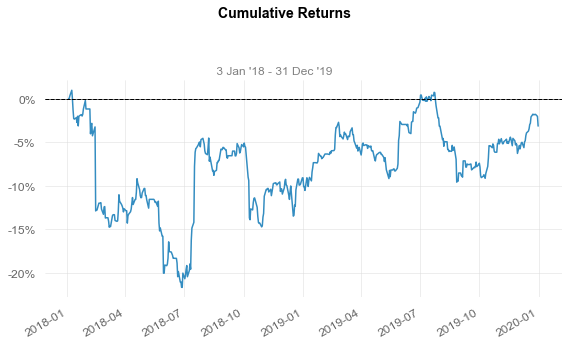

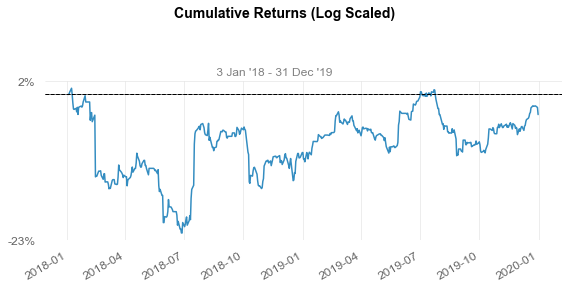

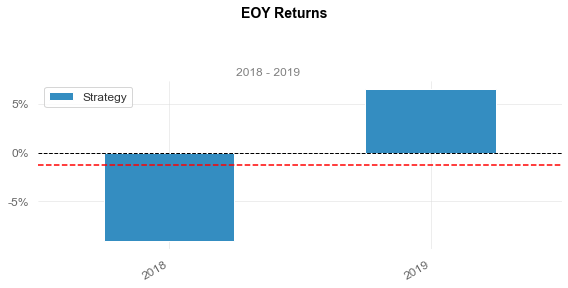

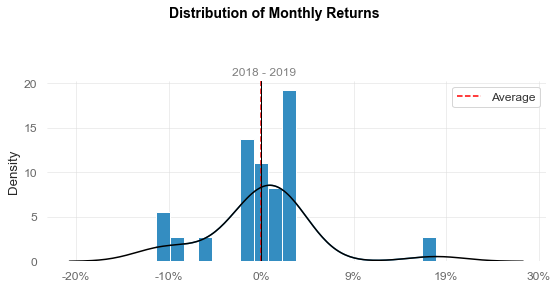

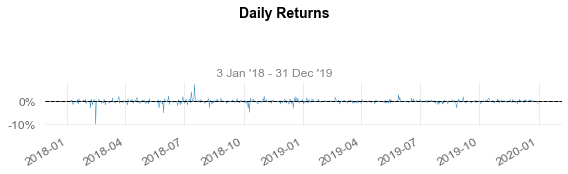

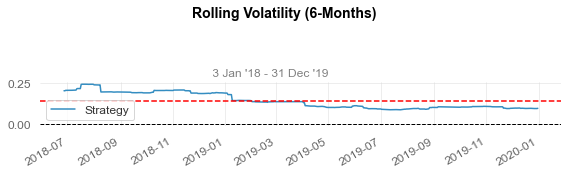

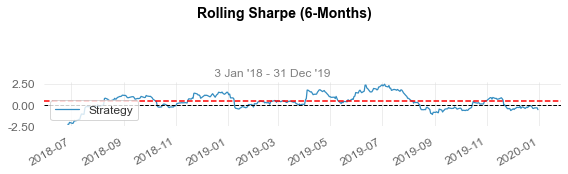

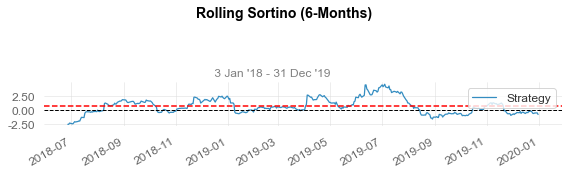

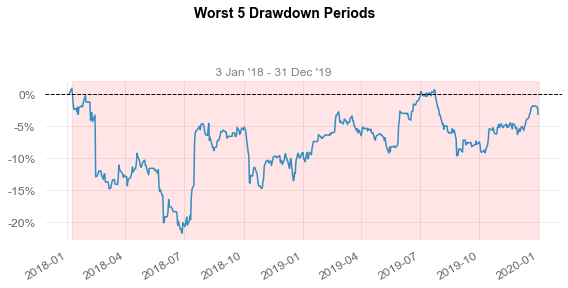

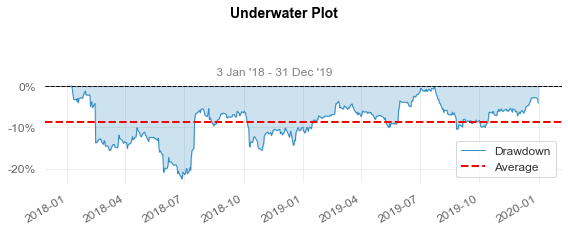

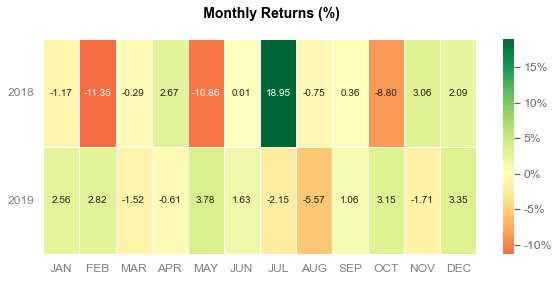

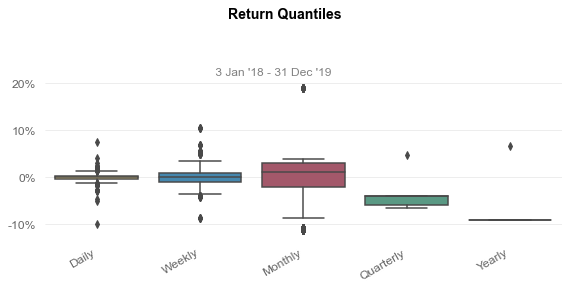

In [8]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# RSI 70 / 30 baseline

In [9]:
env = env_maker_val()
observation = env.reset()

c = 0
action = np.zeros(len(TICKERS) + 1, dtype=np.float)
cash_holding = []
stock_ts = 0
while True:
    for i, ticker in enumerate(TICKERS):
        if df[ticker].iloc[val_start + c].RSI_14D > 70.:
            action[i + 1] = 1.
        elif df[ticker].iloc[val_start + c].RSI_14D < 30:
            action[i + 1] = 0.

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break


print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

AMM
CIMB
DIGI
GAM
GENM
GENT
HLBK
IOI
KLK
MAY
MISC
NESZ
PBK
PEP
PETD
PTG
RHBBANK
ROTH
T
TNB
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 12646.128441000003, 'total_profit': 12646.128441000003, 'position': array([  47.298441,    0.      , 1788.      ,    0.      , 2466.      ,
       2868.      , 1556.      ,    0.      , 2020.      ,  378.      ,
       1089.      , 1125.      ,   64.      ,    0.      ,  492.      ,
          0.      ,    0.      , 1637.      ,    0.      ,    0.      ,
        701.      ]), 'delta': array([-21.91,   0.  ,  -1.  ,   0.  ,  23.  , -31.  ,   5.  ,   0.  ,
        12.  ,  -4.  , -12.  ,   2.  ,   0.  ,   0.  ,  13.  ,   0.  ,
         0.  ,  14.  ,   0.  ,   0.  , -14.  ]), 'net_worth': 112646.1284409998}
Iterations: 521
Average cash: 0.12697648944727033
Time steps with stock: 100.0


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             94.0%

Cumulative Return          15.56%
CAGR﹪                     7.53%

Sharpe                     0.79
Smart Sharpe               0.78
Sortino                    1.13
Smart Sortino              1.11
Sortino/√2                 0.8
Smart Sortino/√2           0.78
Omega                      1.15

Max Drawdown               -7.95%
Longest DD Days            179
Volatility (ann.)          9.44%
Calmar                     0.95
Skew                       -0.26
Kurtosis                   2.11

Expected Daily %           0.03%
Expected Monthly %         0.6%
Expected Yearly %          7.5%
Kelly Criterion            7.03%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.95%
Expected Shortfall (cVaR)  -0.95%

Gain/Pain Ratio            0.15
Gain/Pain (1M)             1.35

P

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-07-05,2019-09-03,2019-12-31,179,-7.947190,-6.783879
2,2018-11-09,2018-12-17,2019-02-20,103,-6.055925,-5.741270
3,2018-06-07,2018-07-06,2018-11-05,151,-5.846963,-4.670221
4,2019-02-22,2019-05-14,2019-07-02,130,-5.538060,-5.396642
5,2018-04-20,2018-05-30,2018-06-06,47,-3.977298,-3.792006


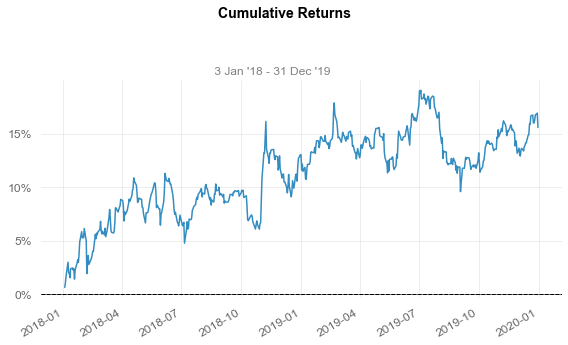

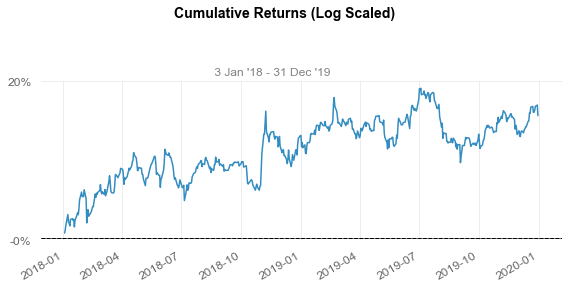

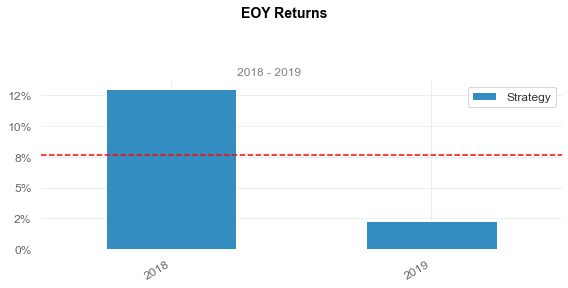

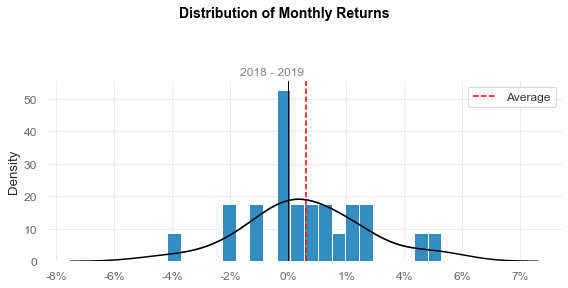

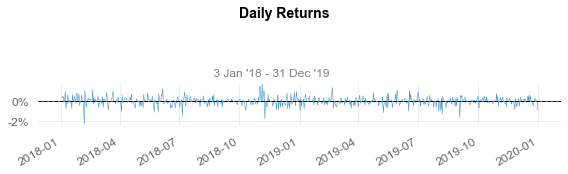

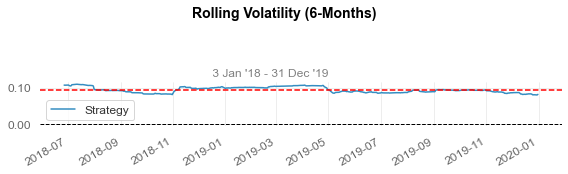

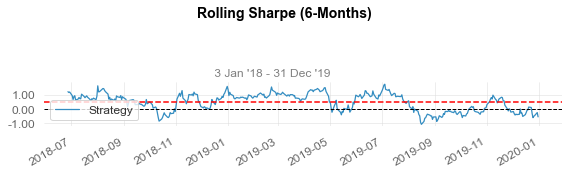

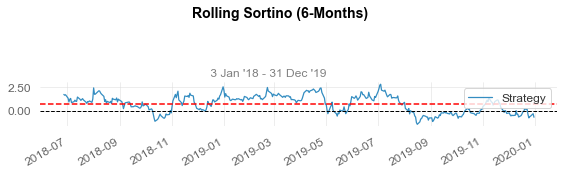

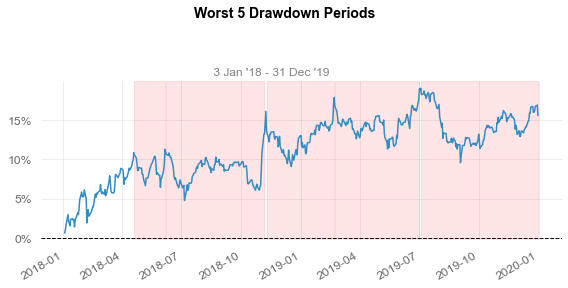

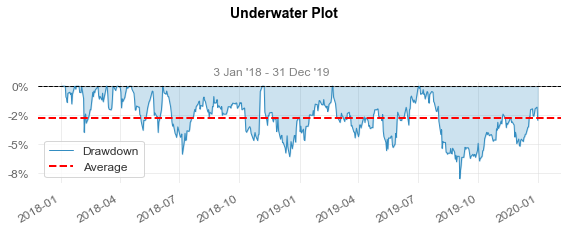

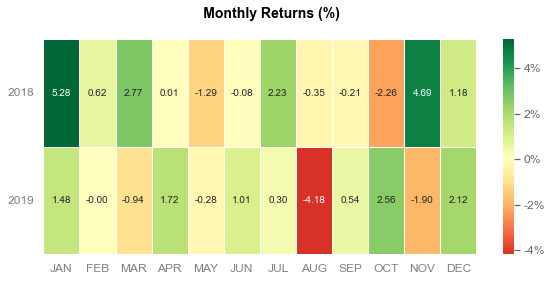

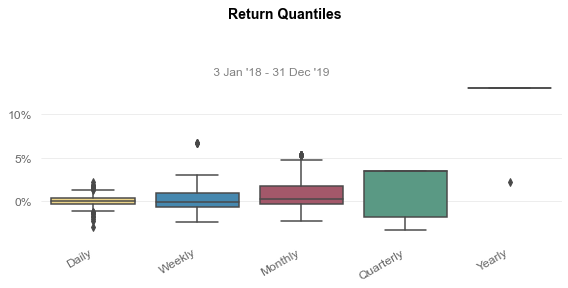

In [10]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Average Model Baseline

In [11]:
env = env_maker_val()
observation = env.reset()

c = 0
cash_holding = []
stock_ts = 0
while True:
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i, ticker in enumerate(TICKERS):
        if directions_df[ticker].iloc[c].AVG == 1.:
            action[i + 1] = 1.

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break


print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

AMM
CIMB
DIGI
GAM
GENM
GENT
HLBK
IOI
KLK
MAY
MISC
NESZ
PBK
PEP
PETD
PTG
RHBBANK
ROTH
T
TNB
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 21456.26840000004, 'total_profit': 21456.26840000004, 'position': array([  79.9384,    0.    , 1656.    ,    0.    , 2284.    , 2657.    ,
       1441.    ,  499.    , 1871.    ,  350.    , 1008.    ,    0.    ,
          0.    , 2200.    ,  455.    ,  377.    ,    0.    , 1516.    ,
        569.    , 2266.    ,    0.    ]), 'delta': array([   16.412,     0.   ,  -664.   ,     0.   ,  -885.   , -1103.   ,
        1441.   ,   499.   ,  -734.   ,  -145.   ,  -420.   ,     0.   ,
           0.   ,  -892.   ,   455.   ,  -154.   ,  -713.   ,  1516.   ,
         569.   ,  -879.   ,     0.   ]), 'net_worth': 121456.26839999991}
Iterations: 521
Average cash: 0.10567898052658538
Time steps with stock: 100.0


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             94.0%

Cumulative Return          21.76%
CAGR﹪                     10.39%

Sharpe                     0.93
Smart Sharpe               0.85
Sortino                    1.29
Smart Sortino              1.18
Sortino/√2                 0.91
Smart Sortino/√2           0.83
Omega                      1.18

Max Drawdown               -10.35%
Longest DD Days            275
Volatility (ann.)          10.84%
Calmar                     1.0
Skew                       -0.88
Kurtosis                   6.45

Expected Daily %           0.04%
Expected Monthly %         0.82%
Expected Yearly %          10.35%
Kelly Criterion            8.65%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.08%
Expected Shortfall (cVaR)  -1.08%

Gain/Pain Ratio            0.18
Gain/Pain (1M)             1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-08-29,2018-12-17,2019-05-31,275,-10.348341,-9.397295
2,2018-05-18,2018-05-30,2018-07-27,70,-7.916607,-7.632261
3,2019-07-17,2019-08-13,2019-12-18,154,-7.766282,-7.602356
4,2018-03-23,2018-04-04,2018-04-09,17,-3.817800,-2.715924
5,2018-02-05,2018-02-06,2018-02-26,21,-3.497864,-3.321310


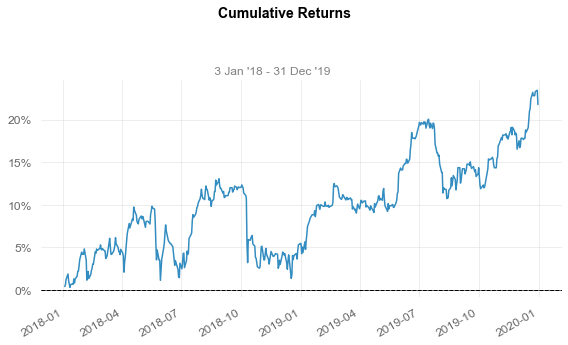

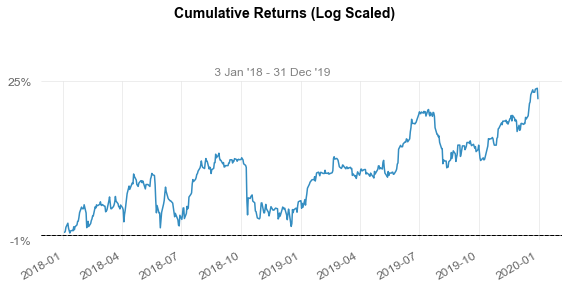

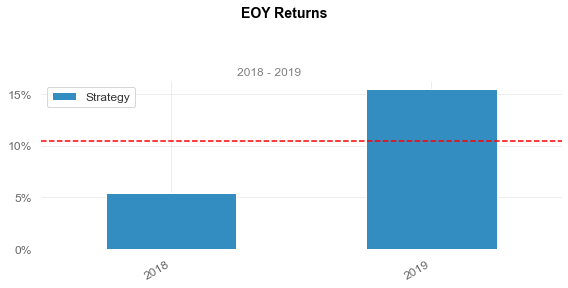

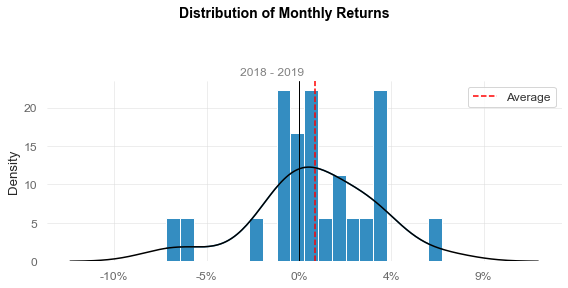

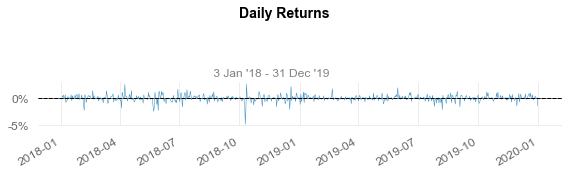

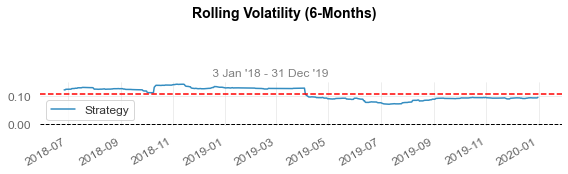

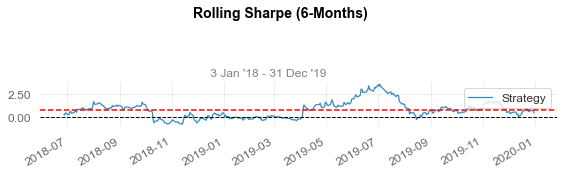

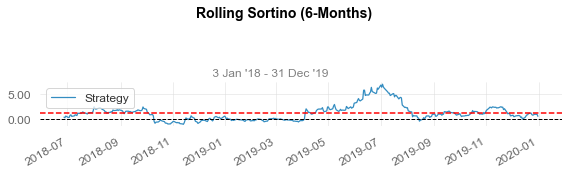

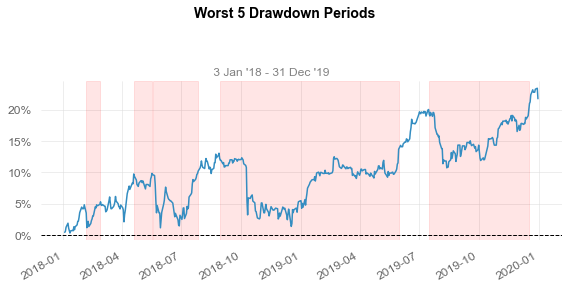

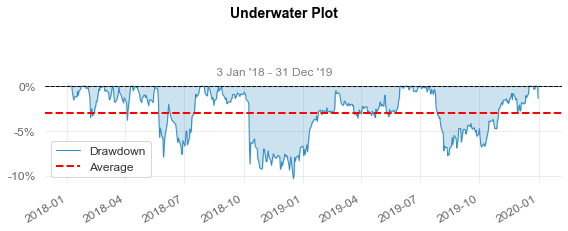

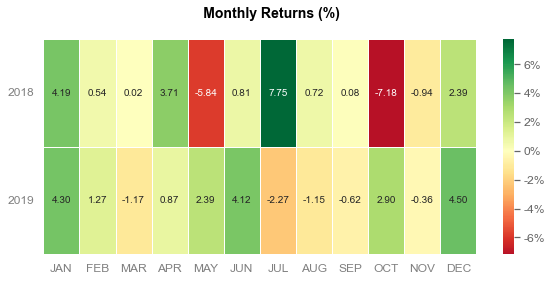

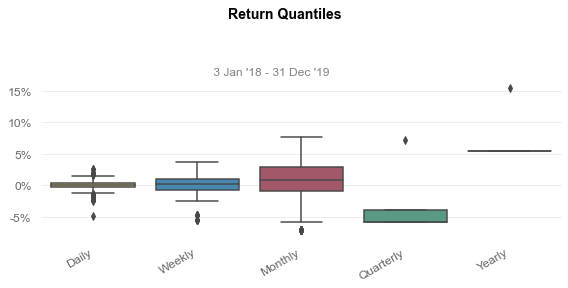

In [12]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Consensus Model baseline

In [13]:
env = env_maker_val()
observation = env.reset()

c = 0
stock_ts = 0
cash_holding = []
while True:
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i, ticker in enumerate(TICKERS):
        if np.all([directions_df[ticker].iloc[c][f"MODEL_{j+1}"] == 1. for j in range(10)]):
            action[i + 1] = 1.

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break


print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

AMM
CIMB
DIGI
GAM
GENM
GENT
HLBK
IOI
KLK
MAY
MISC
NESZ
PBK
PEP
PETD
PTG
RHBBANK
ROTH
T
TNB
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 52512.417599999884, 'total_profit': 52512.417599999884, 'position': array([1.3456e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6608e+04, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9534e+04, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00]), 'delta': array([  -38.154,     0.   ,     0.   ,     0.   , -7987.   , -9478.   ,
           0.   ,     0.   , 16608.   , -1249.   , -3599.   ,     0.   ,
           0.   , 19534.   ,     0.   , -1340.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ]), 'net_worth': 152512.41759999984}
Iterations: 521
Average cash: 9.05808033569817
Time steps with stock: 90.97888675623801


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             82.0%

Cumulative Return          52.7%
CAGR﹪                     23.68%

Sharpe                     1.49
Smart Sharpe               1.38
Sortino                    2.01
Smart Sortino              1.86
Sortino/√2                 1.42
Smart Sortino/√2           1.32
Omega                      1.37

Max Drawdown               -16.12%
Longest DD Days            301
Volatility (ann.)          14.43%
Calmar                     1.47
Skew                       -2.11
Kurtosis                   20.77

Expected Daily %           0.08%
Expected Monthly %         1.78%
Expected Yearly %          23.57%
Kelly Criterion            16.17%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.41%
Expected Shortfall (cVaR)  -1.41%

Gain/Pain Ratio            0.37
Gain/Pain (1M)            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-10-04,2018-12-17,2019-08-01,301,-16.119631,-15.097762
2,2019-09-23,2019-10-09,2019-11-20,58,-7.450651,-6.899800
3,2018-03-23,2018-04-04,2018-05-03,41,-6.087716,-5.615320
4,2019-11-21,2019-11-29,2019-12-12,21,-3.685406,-3.363621
5,2018-07-03,2018-07-12,2018-07-18,15,-3.649799,-2.846779


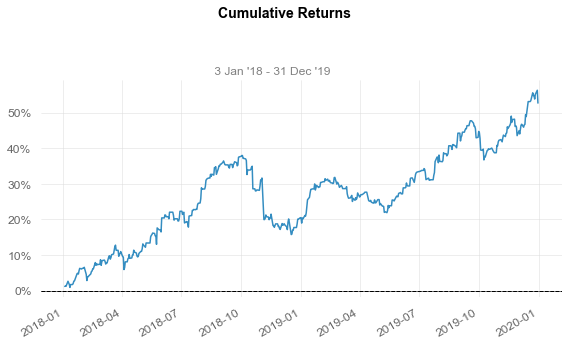

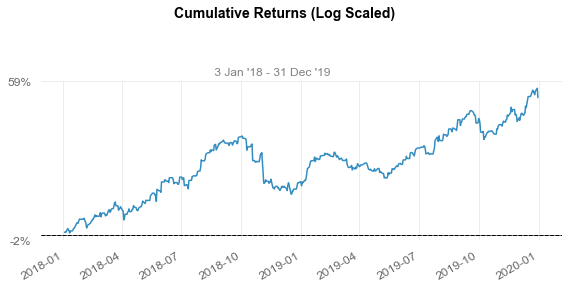

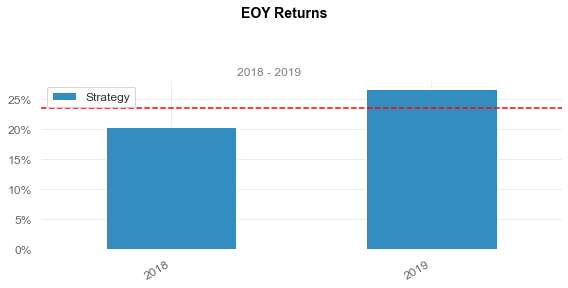

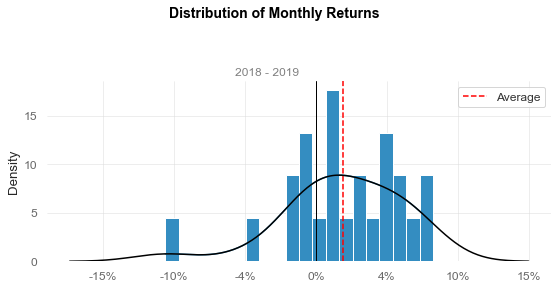

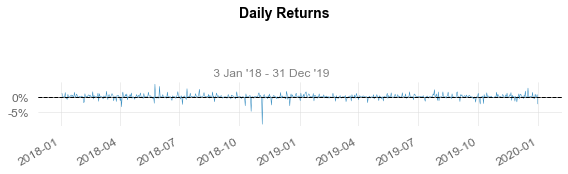

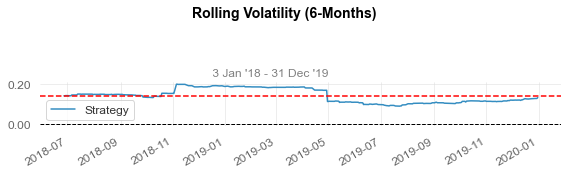

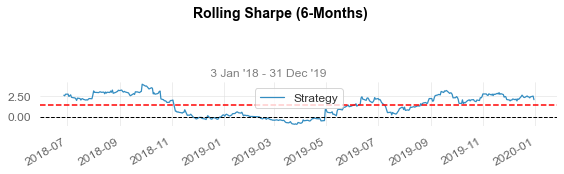

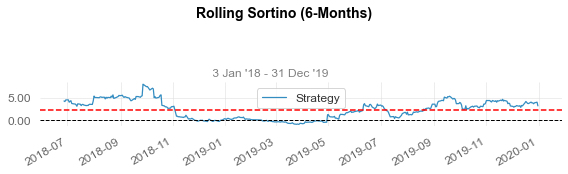

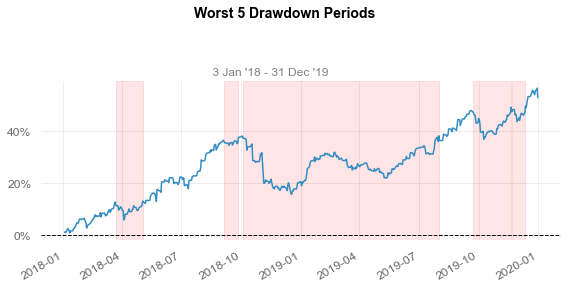

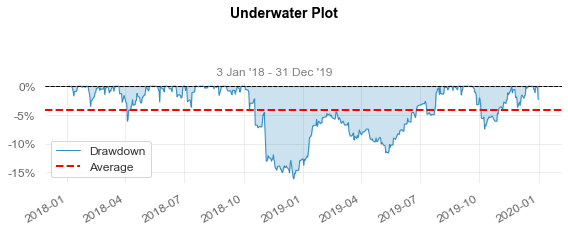

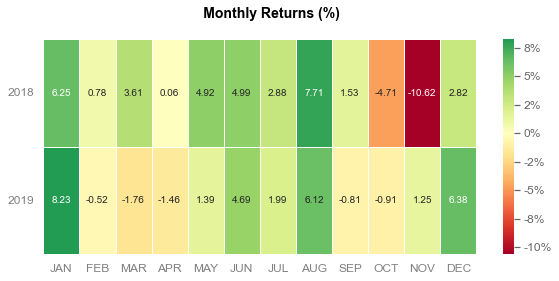

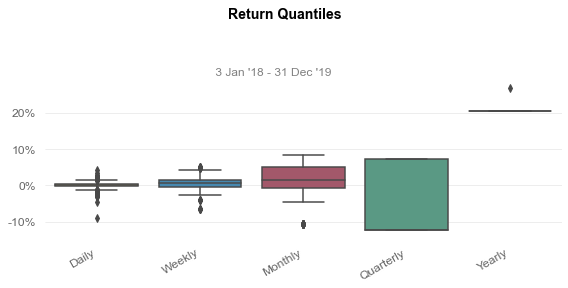

In [14]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Proportional baseline

In [15]:
env = env_maker_val()
observation = env.reset()

c = 0
stock_ts = 0
cash_holding = []
while True:
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i, ticker in enumerate(TICKERS):
        action[i + 1] = np.sum([1 if directions_df[ticker].iloc[c][f"MODEL_{j+1}"] == 1. else 0. for j in range(10)])
        action[i + 1] = max(action[i + 1] - 4, 0.)

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

AMM
CIMB
DIGI
GAM
GENM
GENT
HLBK
IOI
KLK
MAY
MISC
NESZ
PBK
PEP
PETD
PTG
RHBBANK
ROTH
T
TNB
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 32639.80480000002, 'total_profit': 32639.80480000002, 'position': array([  73.6468,    0.    , 1948.    ,    0.    , 2687.    , 3125.    ,
       1017.    ,  587.    , 2641.    ,  412.    ,  711.    ,    0.    ,
          0.    , 3106.    ,  321.    ,  443.    ,    0.    , 1783.    ,
        536.    , 2666.    ,    0.    ]), 'delta': array([   19.746,     0.   ,   894.   ,     0.   , -1634.   , -2003.   ,
        1017.   ,   270.   ,   273.   ,  -264.   , -1236.   ,     0.   ,
           0.   ,  2404.   ,   180.   ,  -282.   ,  -162.   ,   826.   ,
         536.   ,  -907.   ,     0.   ]), 'net_worth': 132639.8047999995}
Iterations: 521
Average cash: 0.10842155951523949
Time steps with stock: 100.0


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             94.0%

Cumulative Return          33.32%
CAGR﹪                     15.53%

Sharpe                     1.35
Smart Sharpe               1.24
Sortino                    1.88
Smart Sortino              1.73
Sortino/√2                 1.33
Smart Sortino/√2           1.22
Omega                      1.28

Max Drawdown               -10.03%
Longest DD Days            275
Volatility (ann.)          10.72%
Calmar                     1.55
Skew                       -0.88
Kurtosis                   4.62

Expected Daily %           0.06%
Expected Monthly %         1.21%
Expected Yearly %          15.46%
Kelly Criterion            12.5%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.05%
Expected Shortfall (cVaR)  -1.05%

Gain/Pain Ratio            0.28
Gain/Pain (1M)             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-08-29,2018-12-17,2019-05-31,275,-10.027638,-9.193356
2,2018-05-21,2018-05-30,2018-07-31,71,-7.794281,-6.851109
3,2019-07-25,2019-08-13,2019-10-31,98,-5.334433,-5.289724
4,2018-03-23,2018-04-04,2018-04-11,19,-4.273134,-3.336926
5,2018-02-05,2018-02-06,2018-02-19,14,-3.547721,-3.013378


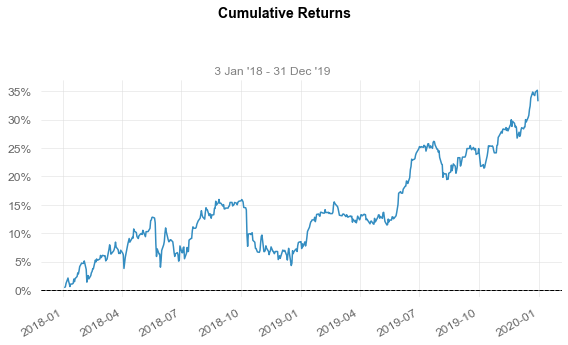

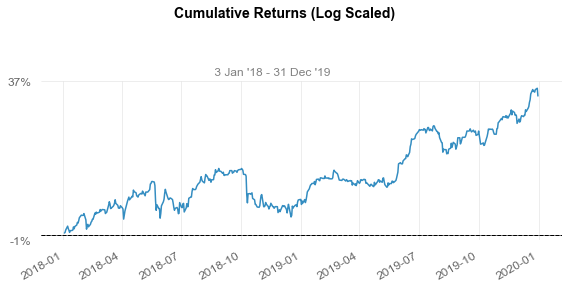

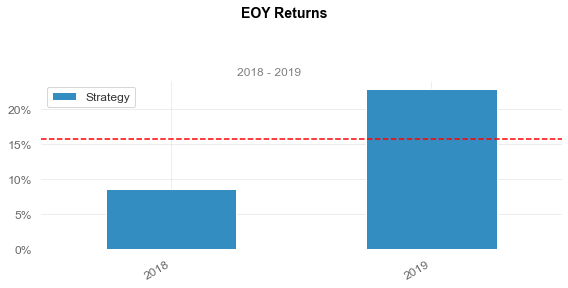

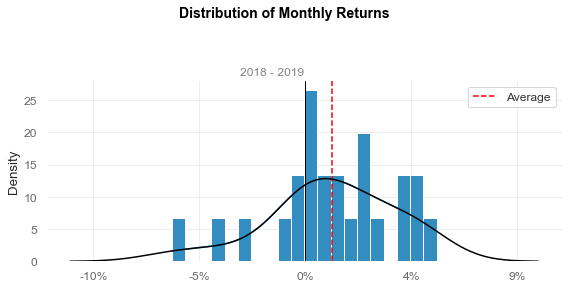

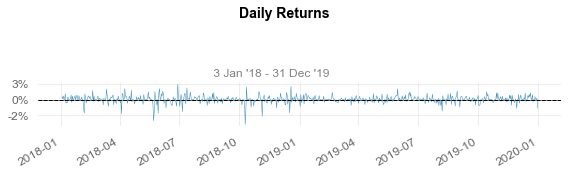

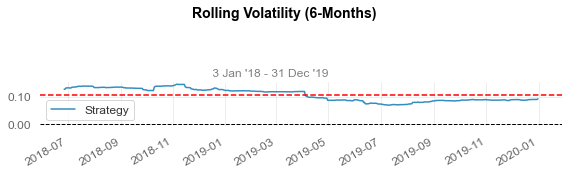

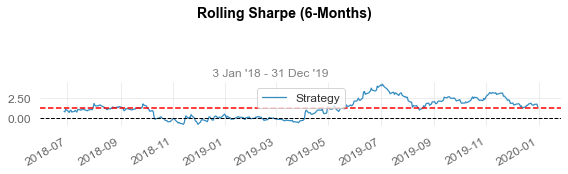

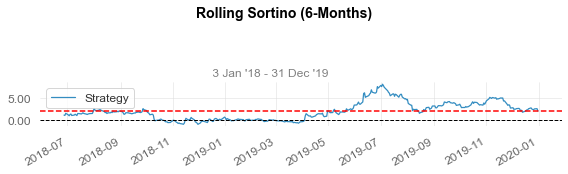

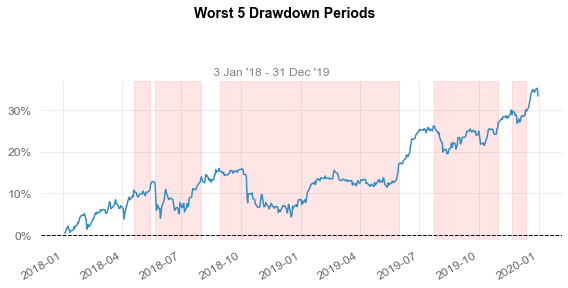

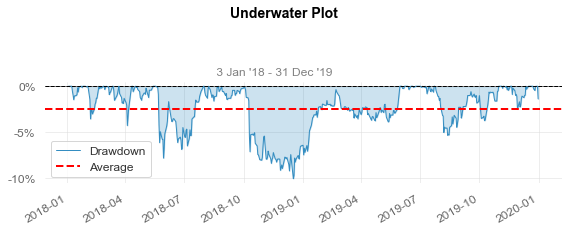

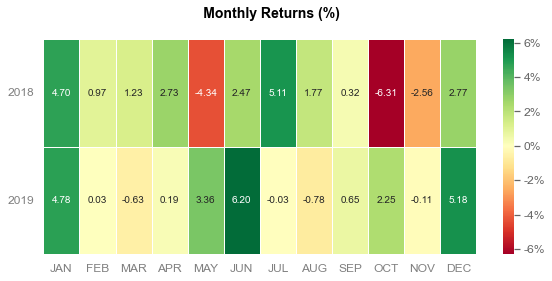

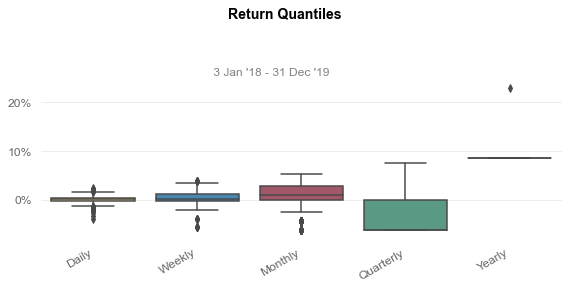

In [16]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Need 8 model

In [17]:
env = env_maker_val()
observation = env.reset()

c = 0
stock_ts = 0
cash_holding = []
while True:
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i, ticker in enumerate(TICKERS):
        n_models = np.sum([1 if directions_df[ticker].iloc[c][f"MODEL_{j+1}"] == 1. else 0. for j in range(10)])
        if n_models >= 8:
            action[i + 1] = 1.

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

AMM
CIMB
DIGI
GAM
GENM
GENT
HLBK
IOI
KLK
MAY
MISC
NESZ
PBK
PEP
PETD
PTG
RHBBANK
ROTH
T
TNB
From 2017-11-20 00:00:00 to 2019-12-31 00:00:00
Continuous action space
Info: {'total_reward': 33441.76530000003, 'total_profit': 33441.76530000003, 'position': array([  78.2693,    0.    , 2315.    ,    0.    , 3194.    , 3715.    ,
          0.    ,  698.    , 2616.    ,  489.    ,    0.    ,    0.    ,
          0.    , 3077.    ,    0.    ,  527.    ,    0.    , 2120.    ,
        796.    , 3169.    ,    0.    ]), 'delta': array([   33.668,     0.   ,  2315.   ,     0.   , -1768.   , -2173.   ,
           0.   ,   698.   , -1463.   ,  -287.   , -2236.   ,     0.   ,
           0.   ,  3077.   ,     0.   ,  -305.   ,     0.   ,  2120.   ,
         796.   , -1755.   ,     0.   ]), 'net_worth': 133441.76530000023}
Iterations: 521
Average cash: 0.26944765120563524
Time steps with stock: 99.80806142034548


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             94.0%

Cumulative Return          34.44%
CAGR﹪                     16.02%

Sharpe                     1.28
Smart Sharpe               1.23
Sortino                    1.88
Smart Sortino              1.79
Sortino/√2                 1.33
Smart Sortino/√2           1.27
Omega                      1.26

Max Drawdown               -8.7%
Longest DD Days            127
Volatility (ann.)          11.72%
Calmar                     1.84
Skew                       -0.15
Kurtosis                   5.13

Expected Daily %           0.06%
Expected Monthly %         1.24%
Expected Yearly %          15.95%
Kelly Criterion            11.78%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.16%
Expected Shortfall (cVaR)  -1.16%

Gain/Pain Ratio            0.26
Gain/Pain (1M)             1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-10-03,2018-12-17,2019-02-07,127,-8.701501,-8.289024
2,2019-07-26,2019-08-15,2019-11-20,117,-6.632422,-6.595810
3,2018-05-14,2018-05-30,2018-07-19,66,-6.586413,-5.556213
4,2019-02-22,2019-05-13,2019-06-18,116,-6.289946,-6.285926
5,2018-03-14,2018-04-04,2018-04-09,26,-5.065332,-4.148417


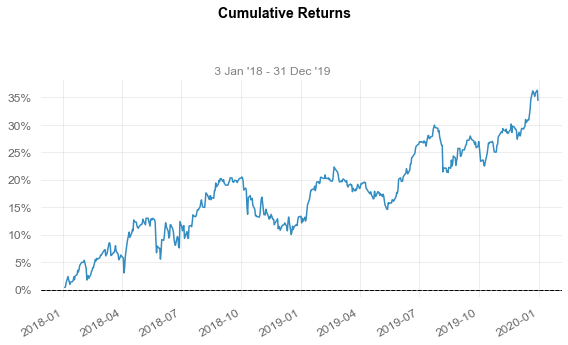

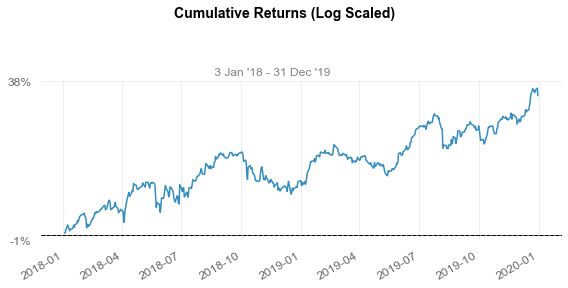

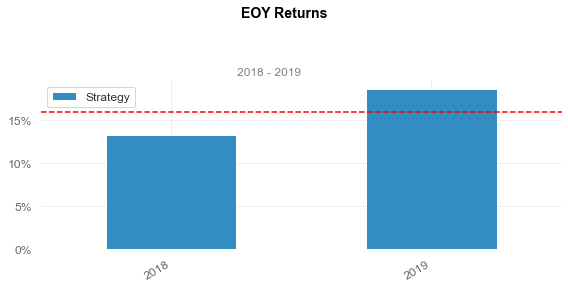

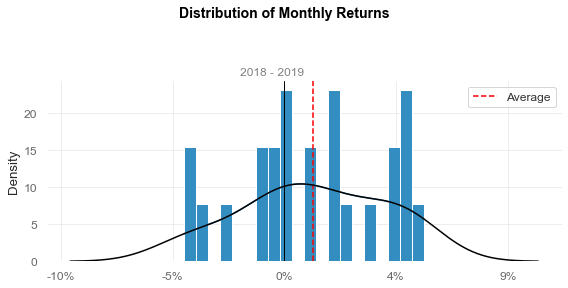

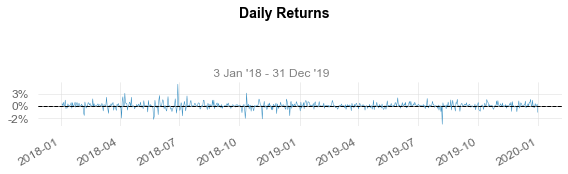

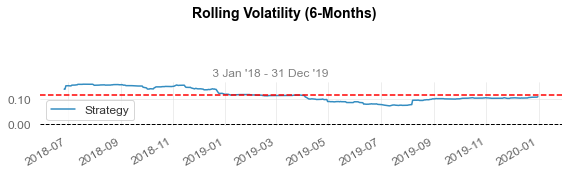

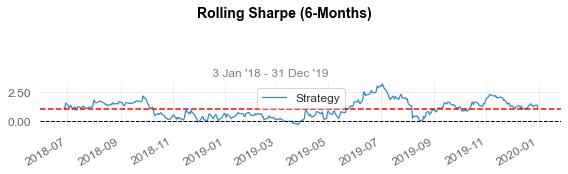

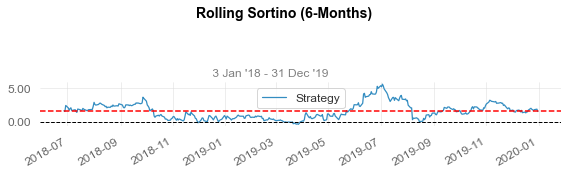

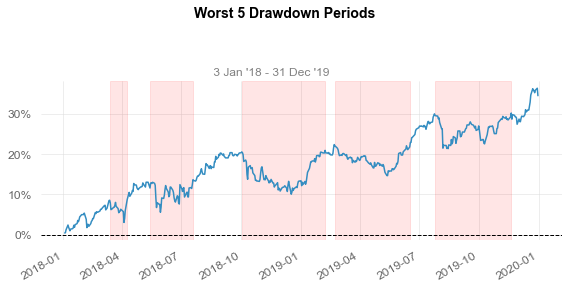

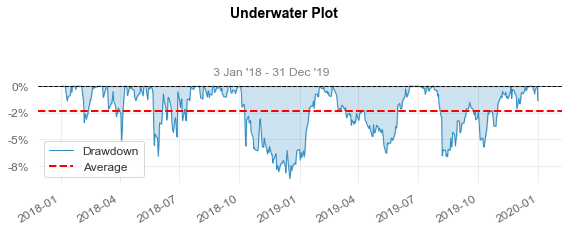

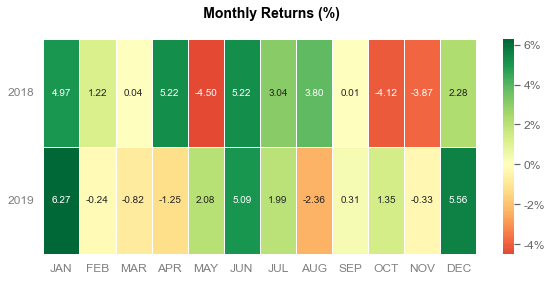

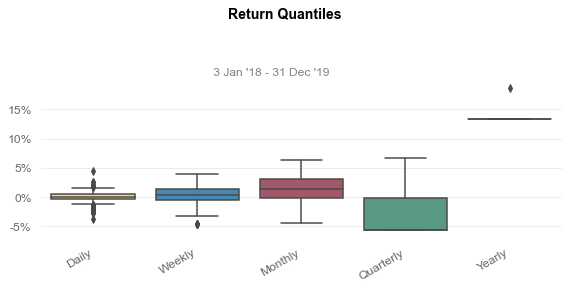

In [18]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)